# INM706 Deep Learning for Sequence Analysis
### Sarah Rhalem (190051884) & Stelios Kliafas (200041011)

### Import Modules & Packages

Draft Notes/ Working comments:
Dataset >> Problem +Evaluation Metric >> Model

In [1]:
#!pip install transformers

In [2]:
import os
import json
import torch
import re
import numpy as np
import pandas as pd
import csv
import random
import time
import random
import torch.nn as nn
import pickle
import warnings
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from matplotlib.ticker import MaxNLocator
from torch.utils.data import Dataset, DataLoader, random_split, SequentialSampler, RandomSampler
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config, AdamW, get_linear_schedule_with_warmup, BertTokenizer, BertForSequenceClassification, BertConfig
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
from nltk.translate.nist_score import corpus_nist
warnings.simplefilter("ignore", UserWarning)

from modules.bert_dataset import *
from modules.bert_train_valid import *
from modules.generate_modules import *
from modules.gpt2_netflix_dataset import *
from modules.gpt2_train_valid import *
from modules.split_datasets_and_create_dataloaders import *
from modules.utils import *


In [3]:
# Set to use GPU on device if available:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
# Working directory
os.getcwd()

'C:\\Users\\public2\\Desktop\\INM706_DL_Sequence_Analysis'

### Loading & Structuring Data

In [5]:
# Load csv dataset, create listing column
raw_dataset_df= pd.read_csv(os.path.join("Data\\netflix_titles.csv") , encoding="utf8")
raw_dataset_df["listing"]= raw_dataset_df["listed_in"].str.split(pat=",", n=1).str.get(0)

# Cleanse Data
raw_dataset_df["description"].isna().sum() # Check null entries for description - None
raw_dataset_df["plot_description"]=raw_dataset_df["description"].map(lambda x: re.sub( r'"', '', x)) #remove quotation marks

# Print example of plot description
raw_dataset_df["description"].to_list()[0]

'In a future where the elite inhabit an island paradise far from the crowded slums, you get one chance to join the 3% saved from squalor.'

In [6]:
# Need to fix this 


# # Exploratory Data Analysis for the Netflix Plot Dataset
# # Maximum length of plot description is < 45 words. Max length of generation will be set to ~50 
# raw_dataset_df['Number_of_words'] = raw_dataset_df.description.apply(lambda x: len(str(x).split(' ')))
# x=raw_dataset_df['Number_of_words']
# plt.hist(raw_dataset_df['Number_of_words'])
# plt.title("Plot samples by number of words", fontsize=11)
# plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)
# plt.text(x.mean() ,2500 ,'average',rotation=90)
# plt.xlabel('Number of Words')
# plt.ylabel('Number of Plot Samples')
# #plt.savefig(os.path.join(path, r'XXXXXXX.jpg'), dpi=300, bbox_inches='tight')
# plt.show()


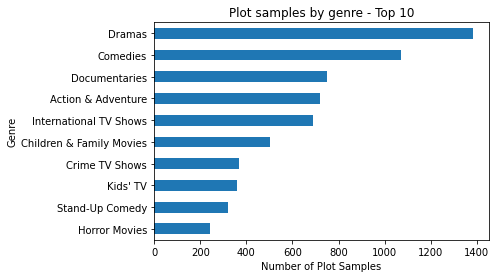

In [7]:
# Plots by genre (top 10) - will map all genres to top 10 genres
#genre_count= raw_dataset_df['listing'].value_counts()
raw_dataset_df.listing.value_counts()[:10].sort_values().plot(kind = 'barh')
plt.title("Plot samples by genre - Top 10")
plt.xlabel("Number of Plot Samples")
plt.ylabel('Genre')
plt.show()

In [8]:
# Map each data sample listing to a generic genre
# Identify the show listings for mapping to summarised genres
raw_dataset_df.listing.value_counts()

# map show listing to a specific genre. Note: Listing types with under ~100 data samples are classified under the genre "Other"
genre_mapping= { "romance": {"Romantic TV Shows", "Romantic Movies"} ,
                "drama": {"Dramas", "TV Dramas"}  ,
                 "comedy": {"Comedies", "Stand-Up Comedy", "TV Comedies", "Stand-Up Comedy & Talk Shows"},
                 "documentary": {"Documentaries", "Docuseries"},
                 "action": {"Action & Adventure", "TV Action & Adventure"} ,
                 "international": {"International TV Shows", "International Movies", "Spanish-Language TV Shows"},
                 "children": {"Children & Family Movies", "Kids' TV"},
                 "crime": {"Crime TV Shows"},
                 "horror": {"Horror Movies", "TV Horror"} ,
                 "anime" : {"Anime Series", "Anime Features"},
                 "other" : {"Thrillers", "British TV Shows", "Reality TV", "Classic & Cult TV", "TV Shows", "TV Sci-Fi & Fantasy",
                         "Classic Movies", "Movies", "Independent Movies", "Cult Movies", "Sports Movies", "LGBTQ Movies", "Music & Musicals",
                         "Sci-Fi & Fantasy"} }

# Add genre column based on listing mapping
raw_dataset_df["genre"] = raw_dataset_df["listing"].map(map_function(genre_mapping))

# Write to txt file
plot_dataset_df= raw_dataset_df[["genre","plot_description"]].copy()
plot_dataset= plot_dataset_df.to_csv('Data\\netflix_plot_dataset.txt', index=False, header=None, sep=":", doublequote=False )

# Sense check - view data header and check all descriptions were mapped
print(plot_dataset_df.head())
print(plot_dataset_df.genre.unique())

           genre                                   plot_description
0  international  In a future where the elite inhabit an island ...
1          drama  After a devastating earthquake hits Mexico Cit...
2         horror  When an army recruit is found dead, his fellow...
3         action  In a postapocalyptic world, rag-doll robots hi...
4          drama  A brilliant group of students become card-coun...
['international' 'drama' 'horror' 'action' 'crime' 'documentary' 'other'
 'comedy' 'anime' 'children' 'romance']


### GPT-2 Model - Tokenizer and Configuration

In [9]:
# Load Tokenizer and config 
configuration = GPT2Config.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Set pad token to eos token. Padding for GPT-2 occurs on the right so will be set to eos token.
configuration.pad_token_id = configuration.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

# Define special tokens to be used
special_tokens_dict = {
                "bos_token": "<genre>",
                 "sep_token":"<plot>",
                 "unk_token": "<unknown>"
            }
# Add special tokens 
num_of_toks= tokenizer.add_special_tokens(special_tokens_dict)
print('We have added', num_of_toks, 'tokens')


We have added 2 tokens


In [10]:
# Instantiate dataset and return length
dataset=NetflixPlotDataset(tokenizer)
dataset.__len__()

7786

In [11]:
# Example of decoded tokenizer plot sample from the dataset.
tokenizer.decode(dataset[23])

'<genre> drama : <plot> When a middle-aged divorcee returns to Kolkata to visit his ailing father, long-buried memories resurface, bringing new discoveries with them.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>'

## Fine-tuning GPT-2 

### Training & Validation

In [12]:
# load Dataloaders
dataloaders = split_datasets_and_create_dataloaders(dataset, batch_size=10)

Number of Training samples: 5450
Number of Validation samples: 1557
Number of Testing samples: 779


In [13]:
# Re-Instantiate model and corresponding config file, reapply resizing for token embeddings
# Re-run before train_val method is called to ensure that the pretrained model is not being updated after every train call during hyperparameter tuning
configuration = GPT2Config.from_pretrained('gpt2')
configuration.pad_token_id = configuration.eos_token_id

model= GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model= model.to(device)
model.resize_token_embeddings(len(tokenizer)) # resize token embeddings as model is instantiated

#Hyperparameters
EPOCHS=4  
TRAIN_STEPS= len(dataloaders['train_dataloader'])*EPOCHS
WU_RATE= 0.2
WU_STEPS= TRAIN_STEPS * WU_RATE# Warm up rate of ~0.2% 
OPTIM= AdamW(model.parameters(), lr = 3e-5,eps = 1e-8, weight_decay=0.01)
SCHEDULER= get_linear_schedule_with_warmup(optimizer=OPTIM, num_warmup_steps =WU_STEPS, num_training_steps =TRAIN_STEPS)


KeyboardInterrupt: 

In [ ]:
# Run train_val
Test_1= gpt2_train_val(model, dataloaders, tokenizer, starting_epoch=0, optimizer=OPTIM, scheduler=SCHEDULER, epochs=EPOCHS, device=device)


In [ ]:
# Display Train & Validation loss and perplexity plots

fig= plot_train_val_loss(Test_1, "Train & Validation loss");
#fig.savefig(r'Figures\\train_val_loss_4eps_crop.jpg')

fig= plot_train_val_perplexity(Test_1, "Train & Validation Perplexity");
#fig.savefig(r'Figures\\train_val_perplexity_4eps_crop.jpg')

In [ ]:
# Plot train/val loss and perplexity
fig= plot_train_loss(Test_1, "Train loss");
#fig.savefig(r'Figures\\train_loss_4eps.jpg')

fig= plot_val_loss(Test_1, "Validation loss");
#fig.savefig(r'Figures\\val_loss_4eps.jpg')

fig= plot_train_perplexity(Test_1, "Train Perplexity");
#fig.savefig(r'Figures\\train_perplexity_4eps.jpg')

fig= plot_val_perplexity(Test_1, "Validation Perplexity");
#fig.savefig(r'Figures\\val_perplexity_4eps.jpg')


In [ ]:
Test_1

## Evaluating fine-tuned GPT-2 model 

### Testing and generating plots

In [ ]:
# Instantiate model, apply resizing for token embeddings - re-run instantiation before training
configuration = GPT2Config.from_pretrained('gpt2')
configuration.pad_token_id = configuration.eos_token_id

model= GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model= model.to(device)
model.resize_token_embeddings(len(tokenizer))

dataloaders = split_datasets_and_create_dataloaders(dataset, batch_size=10)

EPOCHS=10
TRAIN_STEPS= len(dataloaders['train_dataloader'])*EPOCHS
WU_RATE= 0.2
WU_STEPS= TRAIN_STEPS * WU_RATE# Warm up rate of ~0.2% 
OPTIM= AdamW(model.parameters(), lr = 3e-5,eps = 1e-8, weight_decay=0.01)
SCHEDULER= get_linear_schedule_with_warmup(optimizer=OPTIM, num_warmup_steps =WU_STEPS, num_training_steps =TRAIN_STEPS)


#load_checkpoint(model, optimizer=OPTIM, scheduler=SCHEDULER, load_checkpoint_path= "checkpoint_4.pth.tar")

In [ ]:
test_run= test_generate(model, tokenizer, dataloaders, device)

In [ ]:
# Generate 20 plot samples for human analysis and evaluation
set_seed()
test_samples= generate_text(model, tokenizer, device, num_samples=20) 
plot_samples_csv(test_samples, "results/generated_plots_10.csv")

print(*test_samples, sep="\n")


In [ ]:
# Load results from test runs for models trained on 4, 5, 10 and 15 epochs.

test_results_4eps=load_test_results("Results/test_results_4eps.pickle")
test_results_5eps=load_test_results("Results/test_results_5eps.pickle")
test_results_10eps=load_test_results("Results/test_results_10eps.pickle")
test_results_15eps=load_test_results("Results/test_results_15eps.pickle")

print("test_results_4eps:", test_results_4eps)

print("test_results_5eps:", test_results_5eps)

print("test_results_10eps:", test_results_10eps)

print("test_results_15eps:", test_results_15eps)

# GPT-2 Vanilla
### Test vanilla GPT-2 (without fine-tuning) 

In [ ]:
configuration = GPT2Config.from_pretrained('gpt2')
configuration.pad_token_id = configuration.eos_token_id

model= GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model= model.to(device)
model.resize_token_embeddings(len(tokenizer))

test_vanilla= test_generate(model, tokenizer, dataloaders, device)

In [ ]:
# Vanilla GPT-2 generated samples example
test_samples= generate_text(model, tokenizer, device, num_samples=10) 
print(*test_samples, sep="\n")


### BERT - Section

In [14]:
bert_df = pd.get_dummies(plot_dataset_df, columns=["genre"])

In [15]:
bert_df.head()

,plot_description,genre_action,genre_anime,genre_children,genre_comedy,genre_crime,genre_documentary,genre_drama,genre_horror,genre_international,genre_other,genre_romance
0,In a future where the elite inhabit an island ...,0,0,0,0,0,0,0,0,1,0,0
1,After a devastating earthquake hits Mexico Cit...,0,0,0,0,0,0,1,0,0,0,0
2,"When an army recruit is found dead, his fellow...",0,0,0,0,0,0,0,1,0,0,0
3,"In a postapocalyptic world, rag-doll robots hi...",1,0,0,0,0,0,0,0,0,0,0
4,A brilliant group of students become card-coun...,0,0,0,0,0,0,1,0,0,0,0


In [16]:
plot_dataset_df["genre"] = plot_dataset_df["genre"].astype('category')
plot_dataset_df["genre_codes"] = plot_dataset_df['genre'].cat.codes
plot_dataset_df.head()

,genre,plot_description,genre_codes
0,international,In a future where the elite inhabit an island ...,8
1,drama,After a devastating earthquake hits Mexico Cit...,6
2,horror,"When an army recruit is found dead, his fellow...",7
3,action,"In a postapocalyptic world, rag-doll robots hi...",0
4,drama,A brilliant group of students become card-coun...,6


In [17]:
plot_dataset_df["genre_codes"].max() # Number of label classes

10

In [18]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
plot_dataset_df["plot_description"] = [" ".join([word for word in sentence.lower().split() if word not in stopwords]) for sentence in plot_dataset_df["plot_description"].tolist()]
movie_plots = plot_dataset_df.plot_description.values

In [19]:
print(plot_dataset_df)

              genre                                   plot_description  \
0     international  future elite inhabit island paradise far crowd...   
1             drama  devastating earthquake hits mexico city, trapp...   
2            horror  army recruit found dead, fellow soldiers force...   
3            action  postapocalyptic world, rag-doll robots hide fe...   
4             drama  brilliant group students become card-counting ...   
...             ...                                                ...   
7781          drama  lebanon's civil war deprives zozo family, he's...   
7782          drama  scrappy poor boy worms way tycoon's dysfunctio...   
7783    documentary  documentary, south african rapper nasty c hits...   
7784  international  dessert wizard adriano zumbo looks next “willy...   
7785    documentary  documentary delves mystique behind blues-rock ...   

      genre_codes  
0               8  
1               6  
2               7  
3               0  
4          

In [20]:
print(movie_plots)

['future elite inhabit island paradise far crowded slums, get one chance join 3% saved squalor.'
 'devastating earthquake hits mexico city, trapped survivors walks life wait rescued trying desperately stay alive.'
 "army recruit found dead, fellow soldiers forced confront terrifying secret that's haunting jungle island training camp."
 ...
 "documentary, south african rapper nasty c hits stage streets tokyo, introducing city's sights, sounds culture."
 'dessert wizard adriano zumbo looks next “willy wonka” tense competition finds skilled amateurs competing $100,000 prize.'
 'documentary delves mystique behind blues-rock trio explores enigmatic band created iconic look sound.']


In [21]:
config = BertConfig.from_pretrained('bert-base-uncased', num_labels=2)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True,)
model = BertForSequenceClassification(config)

In [ ]:
bert_dataset = BertDataset(movie_plots, labels, tokenizer)
bert_dataset.__len__()

In [ ]:
BATCH_SIZE = 10
dataloaders = split_datasets_and_create_dataloaders(bert_dataset, batch_size=BATCH_SIZE)

In [ ]:
#Hyperparameters
EPOCHS=4  
TRAIN_STEPS= len(dataloaders['train_dataloader'])*EPOCHS
WU_RATE= 0.2
WU_STEPS= TRAIN_STEPS * WU_RATE# Warm up rate of ~0.2% 
OPTIM= AdamW(model.parameters(), lr = 3e-5,eps = 1e-8, weight_decay=0.01)
SCHEDULER= get_linear_schedule_with_warmup(optimizer=OPTIM, num_warmup_steps =WU_STEPS, num_training_steps =TRAIN_STEPS)

In [ ]:
Test_bert= bert_train_val(model, dataloaders,starting_epoch=0, optimizer=OPTIM, scheduler=SCHEDULER, epochs=EPOCHS, batch_size=BATCH_SIZE, device=device)

In [ ]:
# Display Train & Validation loss and perplexity plots

fig= plot_train_val_loss(Test_bert, "Train & Validation loss");
#fig.savefig(r'Figures\\train_val_loss_4eps_crop.jpg')
print("")
fig= plot_train_val_accuracy(Test_bert, "Train & Validation Accuracy");
#fig.savefig(r'Figures\\train_val_perplexity_4eps_crop.jpg')

In [ ]:
# Plot train/val loss and perplexity
fig= plot_train_loss(Test_bert, "Train loss");
#fig.savefig(r'Figures\\train_loss_4eps.jpg')

fig= plot_val_loss(Test_bert, "Validation loss");
#fig.savefig(r'Figures\\val_loss_4eps.jpg')

fig= plot_train_accuracy(Test_bert, "Train Accuracy");
#fig.savefig(r'Figures\\train_perplexity_4eps.jpg')

fig= plot_val_accuracy(Test_bert, "Validation Accuracy");
#fig.savefig(r'Figures\\val_perplexity_4eps.jpg')


#### IGNORE BELOW - WORKING CODE